# Data exploration 

In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import esda
#----Visulisation----
import contextily
import matplotlib.pyplot as plt
from splot import esda as esdaplot
%matplotlib inline

Load the data set and clean it 

In [3]:
df_chicago=pd.read_csv('Crime/Crimes_-_2001_to_Present.csv',index_col='ID')
# clean the data without geocode and time stamp
df_chicago=df_chicago.dropna(subset=['Date','Location'])
df_chicago['Date']=pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT',inplace=True)

In [4]:
#get geometry point of data
df_chicago['Location'] = df_chicago.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
# get geopandas frame
df_chicago=gpd.GeoDataFrame(df_chicago,geometry='Location')

Now combine the data set with the [boundary data of chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

In [5]:
geof='Crime/Boundaries - Community Areas (current).geojson'
chicago_area=gpd.read_file(geof)
# only keep teh information of commuity and geometry
chicago_area=chicago_area[['community','area_numbe','geometry']]
chicago_area=chicago_area.rename(columns={'area_numbe':'area_num'})

In [6]:
#set crs to the geo dataframe
df_chicago=df_chicago.set_crs(chicago_area.crs)
#spatial join so that crime points are within different communities
df_chicago= df_chicago.sjoin(chicago_area, how='inner',predicate='within')

In [7]:
df_chicago.head()

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,index_right,community,area_num
ID,,,,,,,,,,,,,,,,,,,,,
10224853,HY411790,2015-09-05 16:15:00,041XX W FIFTH AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,SIDEWALK,True,False,1132,...,1148735.0,1896483.0,2015,09/17/2015 11:37:18 AM,41.871884,-87.729404,POINT (-87.72940 41.87188),26,WEST GARFIELD PARK,26
10232192,HY419551,2015-09-10 16:00:00,039XX W GLADYS AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,1132,...,1150207.0,1898066.0,2015,02/10/2018 03:50:01 PM,41.876199,-87.723958,POINT (-87.72396 41.87620),26,WEST GARFIELD PARK,26
10329071,HY519515,2015-11-29 15:00:00,038XX W WILCOX ST,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,OTHER,False,False,1122,...,1150799.0,1899061.0,2015,02/10/2018 03:50:01 PM,41.878918,-87.721758,POINT (-87.72176 41.87892),26,WEST GARFIELD PARK,26
10240564,HY428120,2015-09-17 20:00:00,039XX W WASHINGTON BLVD,281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1122,...,1150014.0,1900125.0,2015,02/10/2018 03:50:01 PM,41.881853,-87.724613,POINT (-87.72461 41.88185),26,WEST GARFIELD PARK,26
10242207,HY430128,2015-09-18 22:35:00,044XX W MADISON ST,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,SIDEWALK,True,False,1113,...,1146742.0,1899645.0,2015,02/10/2018 03:50:01 PM,41.880599,-87.736640,POINT (-87.73664 41.88060),26,WEST GARFIELD PARK,26


In [9]:
# check the type and count of crime data
df_chicago.groupby('Primary Type').size().sort_values()


Primary Type
DOMESTIC VIOLENCE                 1
HUMAN TRAFFICKING                67
STALKING                       3798
SEX OFFENSE                   26328
CRIMINAL SEXUAL ASSAULT       28748
OFFENSE INVOLVING CHILDREN    47860
PROSTITUTION                  68595
dtype: int64

In [16]:
# subset data of interest
# 1. get crime against children 
crime_children= df_chicago[df_chicago['Primary Type']=='OFFENSE INVOLVING CHILDREN']
# 2.combine the sexual violence in one category as sex crime to  analysis
target_type=['SEX OFFENSE ','CRIMINAL SEXUAL ASSAULT']
crime_sexual= df_chicago[df_chicago['Primary Type'].isin(target_type)]
print(f'Size of violence against children: {crime_children.shape[0]}')
print(f'Size of violence against women:{crime_sexual.shape[0]}')

Size of violence against children: 47860
Size of violence against women:28748


# Spatial Pattern Analysis
Code in this section is adapted from 
[construct spatial weight matrix](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W)

In [11]:
# Visualise the distribution of different type of violence
# First get the count of crime in different communities
# In this part, the geometry is polygon of communities
count_child=chicago_area.merge(crime_children.groupby('community').size().reset_index(name='crime_count'),on='community')
#child_count.info()
count_sexual=chicago_area.merge(crime_sexual.groupby('community').size().reset_index(name='crime_count'),on='community')


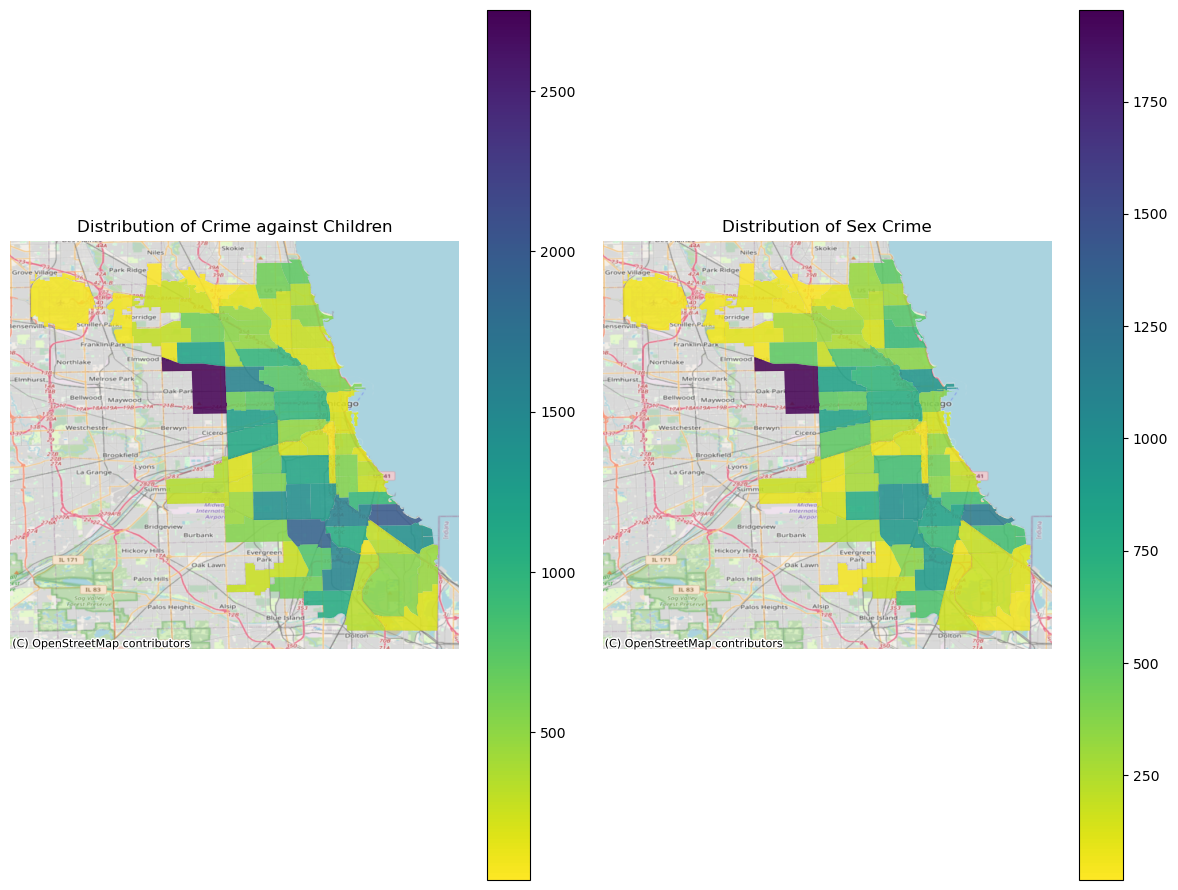

In [20]:
# visualise the distribution of crime count
#set up figure and a single axis
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(12, 9))
# Build choropleth
#ax1=axs[0]
count_child.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[0],
       
)
# add basemap
contextily.add_basemap(
    axs[0],
    crs=count_child.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

# Build choropleth of sex crime
count_sexual.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[1],
       
)
# add basemap
contextily.add_basemap(
    axs[1],
    crs=count_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
# add title
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(["Distribution of Crime against Children",
                  "Distribution of Sex Crime"][i])
fig.tight_layout()

## Spatial Autocorrelation analysis
### Glocal Autocorrelation

In [21]:
#generate spaital weight matrix
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_c=Queen.from_dataframe(count_child)
# row-standardisation
w_c.transform='R'
# get the spatial lag of crime count
count_child['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_c,count_child['crime_count'])
# get the standardised crime count and its spatial lag
count_child['crime_count_std']=count_child['crime_count']-count_child['crime_count'].mean()
count_child['crime_count_lag_std']=count_child['crime_count_lag']-count_child['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_child['crime_count'],w_c)
# retrive the value of Moran's I
print(f"The moran's I for crime against children:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against children:0.30646
empirical p-value:0.001


In [24]:
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_s=Queen.from_dataframe(count_sexual)
# row-standardisation
w_s.transform='R'
# get the spatial lag of crime count
count_sexual['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_s,count_sexual['crime_count'])
# get the standardised crime count and its spatial lag
count_sexual['crime_count_std']=count_sexual['crime_count']-count_sexual['crime_count'].mean()
count_sexual['crime_count_lag_std']=count_sexual['crime_count_lag']-count_sexual['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_sexual['crime_count'],w_s)
# retrive the value of Moran's I
print(f"The moran's I for crime against women:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against women:0.29698
empirical p-value:0.001


### Local Spatial Autocorrelation 


Since the global index does not indicate the type of clustering, local indicator of spatial associations shall be caluclated to examine the geographical clusters of crime.

In [26]:
from esda.moran import Moran_Local
lisa_children= esda.moran.Moran_Local(count_child['crime_count'],w_c)

In [27]:
lisa_sex= esda.moran.Moran_Local(count_sexual['crime_count'],w_s)


In [34]:
# Visulise LISA to find the statistical clusters
# 1. Choropleth of local statistics of each community
# 2. The quadrant each community is assigned into
# 3. The significance of statistics

## In this case let's take the count of crime agaisnt children for example


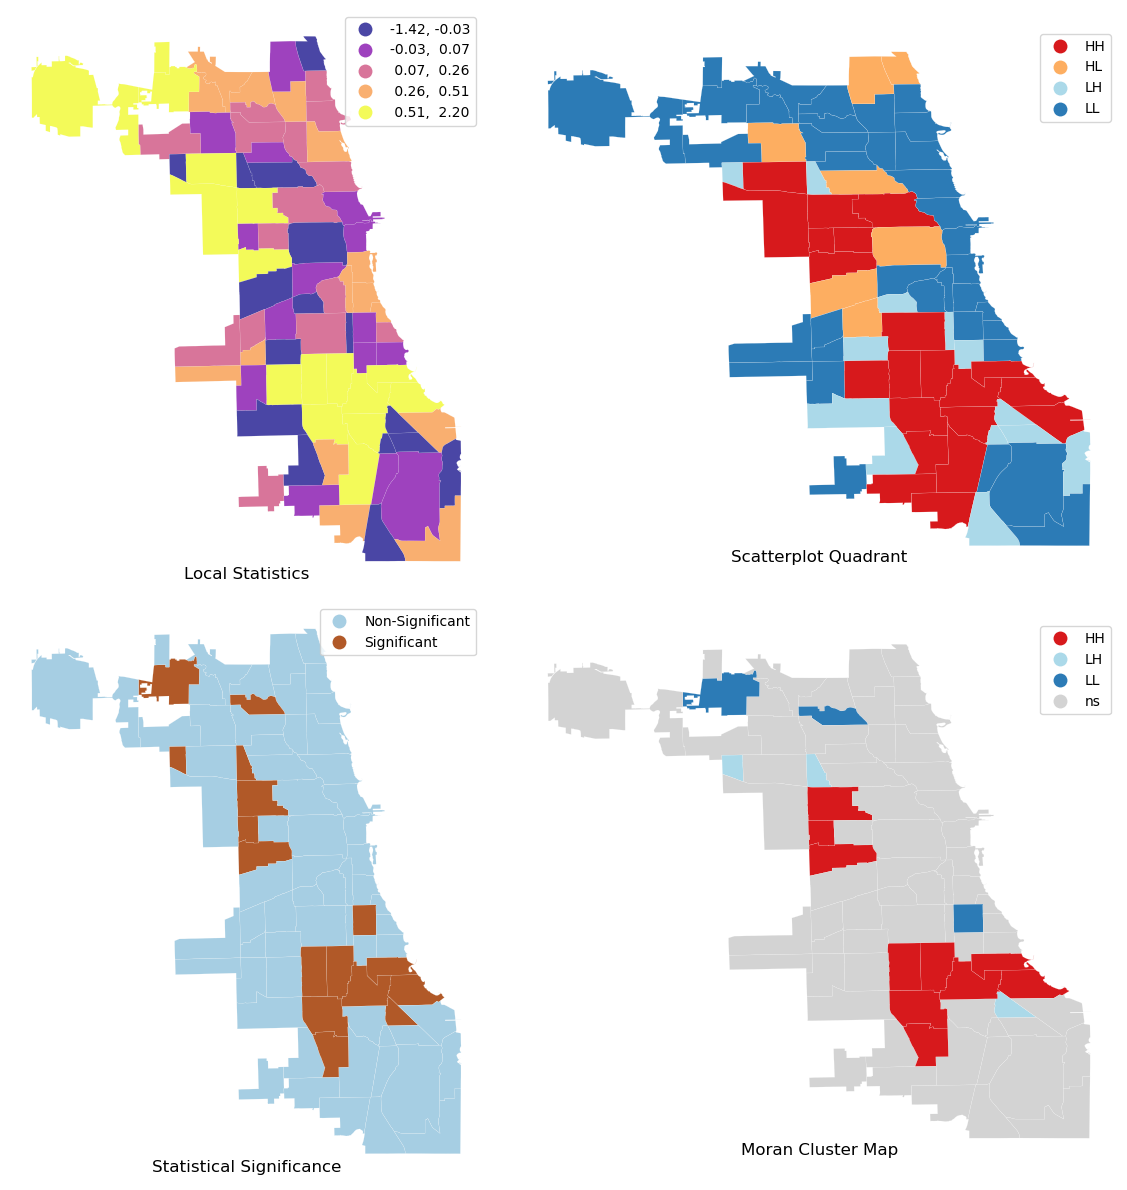

In [35]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
count_child.assign(
    Is=lisa_children.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_children, count_child, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa_children.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=count_child.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
count_child.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
#plt.title("LISA of Crime Against Children")
plt.show()

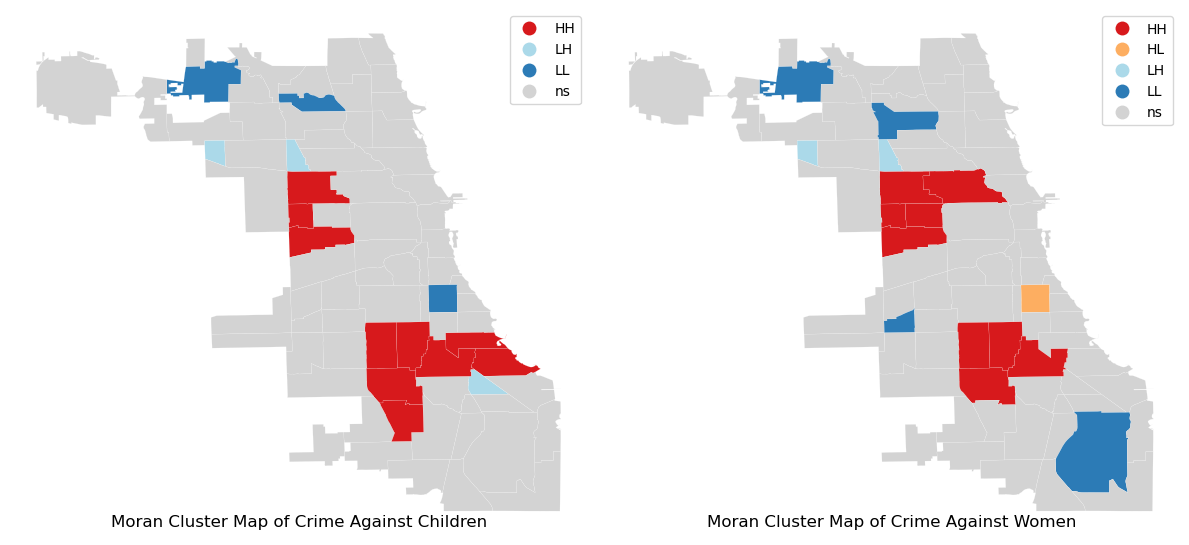

In [28]:
# combine Quadrant categories with significance level to create  cluster map
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Grab second axis of local statistics
ax = axs[0]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)
ax=axs[1]
esdaplot.lisa_cluster(lisa_sex, count_sexual, p=0.05, ax=ax)
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Moran Cluster Map of Crime Against Children",
            "Moran Cluster Map of Crime Against Women",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()


## LISA analysis
Get the hot spot and cold spot of crime counts in Chicago
NB: positive values only
NB: the local I and local G are complementary statistics: The local $ I $ indicates cluster and the local $ G $ shows which side the observation is on

In [36]:
# Gi
go_i =esda.getisord.G_Local(count_child['crime_count'], w_c)

go_i_w = esda.getisord.G_Local(count_sexual['crime_count'], w_s)


TypingError: [1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function matmul>) found for signature:
 
 >>> matmul(array(int64, 2d, C), array(float64, 1d, C))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload in function 'MatMul.generic': File: numba\core\typing\npydecl.py: Line 970.
    With argument(s): '(array(int64, 2d, C), array(float64, 1d, C))':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: [1m'@' arguments must all have the same dtype[0m[0m
  raised from c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\numba\core\typing\npydecl.py:915
[0m
[0m[1mDuring: typing of intrinsic-call at c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\esda\getisord.py (631)[0m
[1m
File "..\..\..\miniconda3\envs\machinel\lib\site-packages\esda\getisord.py", line 631:[0m
[1mdef _g_local_crand(i, z, permuted_ids, weights_i, scaling):
    <source elided>
    zi, zrand = _prepare_univariate(i, z, permuted_ids, other_weights)
[1m    return (zrand @ other_weights) / (scaling - zi)
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001980E4367A0>))[0m
[0m[1mDuring: typing of call at c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\esda\crand.py (335)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001980E4367A0>))[0m
[0m[1mDuring: typing of call at c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\esda\crand.py (335)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001980E4367A0>))[0m
[0m[1mDuring: typing of call at c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\esda\crand.py (335)
[0m
[1m
File "..\..\..\miniconda3\envs\machinel\lib\site-packages\esda\crand.py", line 335:[0m
[1mdef compute_chunk(
    <source elided>
        rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
[1m        if keep:
[0m        [1m^[0m[0m
[0m

In [ ]:

# Gi*
#go_i_star_c = esda.getisord.G_Local(count_child['crime_count'], w_c, star=True)
#go_i_star_w = esda.getisord.G_Local(count_sexual['crime_count'], w_s, star=True)

## KDE analysis


# Temporal analysis


In [61]:
# get the temporal series of crime data
c_temp=crime_children.groupby(pd.Grouper(key='Date',freq='M')).size()
w_temp=crime_sexual.groupby(pd.Grouper(key='Date',freq='M')).size()


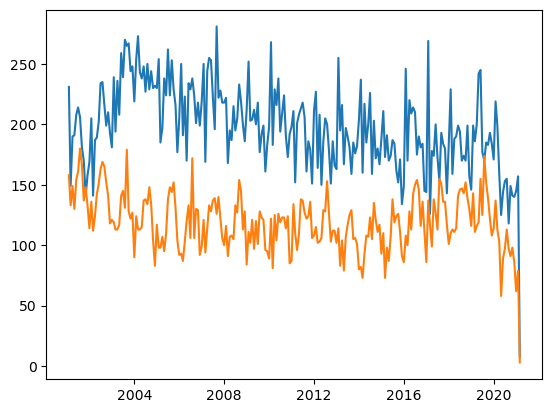

In [63]:
# visualise it
plt.plot(c_temp.index,c_temp.values)
plt.plot(w_temp.index,w_temp.values)

In [64]:
# conduct Augmented Dickey-Fuller Test
# If the ADF statistics has low p-value and close confidence interval, the time-series will be considered as stationary
from statsmodels.tsa.stattools import adfuller
res=adfuller(c_temp.values)
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

ADF Statistics:-0.24152831933380384
p-value:0.9333871079332763
Critical values
	1%: -3.4592326027153493
	5%: -2.8742454699025872
	10%: -2.5735414688888465


# Clustering
## DBSCAN


In [53]:
# get the coordinates of crime point
coords_c=np.array(crime_children[['Longitude','Latitude']],dtype='float64')
coords_w=np.array(crime_sexual[['Longitude','Latitude']],dtype='float64')


In [54]:
# define the number of kilometers in one radian
# the algorithm ball_tree requires radian data
kms_per_radian = 6371.0088
epsilon=0.05/kms_per_radian

In [57]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=epsilon,min_samples=50,algorithm='ball_tree',metric='haversine')
clusters=model.fit(np.radians(coords_c))
labels=clusters.labels_
num_clusters=len(set(labels))
print(f'Number of clusters (children): {len(set(labels))}')

Number of clusters (children): 168
